In [49]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("ticks")
sns.set_context(context="talk")

## READ DATA IN FROM GOOGLE DOCS ##
# see http://gspread.readthedocs.io/en/latest/oauth2.html
import gspread
from oauth2client.service_account import ServiceAccountCredentials
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
credentials = ServiceAccountCredentials.from_json_keyfile_name('/Users/urai/Documents/stuff/IBL-CSHL-citricAcid-dc4fee22cc42.json', scope)
gc = gspread.authorize(credentials)

# now read the doc
doc = gc.open_by_key('1Ne466FpvhqbMQIfuivZRhp_3alBVTgPGSMc0q387frk')

In [86]:
# read all worksheets, make a dictionary with the info that we'll need to add
worksheet_list = [
    {"sheet": "Batch1", "baseline": "free hydrogel", "intervention": "citric acid water"},
    {"sheet": "Batch2", "baseline": "water restriction", "intervention": "citric acid water"},
    {"sheet": "Batch3", "baseline": "free hydrogel", "intervention": "citric acid hydrogel"},
    {"sheet": "Batch4", "baseline": "water restriction", "intervention": "citric acid hydrogel"},
    ]

results = []
for w, entry in enumerate(worksheet_list):
    worksheet = doc.worksheet(entry["sheet"])
    df = pd.DataFrame(worksheet.get_all_records())
    df.drop([''], axis=1, inplace=True) # get rid of extra stuff
    
    # make the date relative to baseline (1st entry)
    df['date'] = pd.to_datetime(df.date)
    df['date'] = df.date - df.date[0]

    # unstack https://deparkes.co.uk/2016/10/28/reshape-pandas-data-with-melt/
    df = pd.melt(df, id_vars="date", var_name="mouse", value_name="weight")
    
    # add some info about the different batches
    df['baseline'] = entry["baseline"]
    df['intervention'] = entry["intervention"]
    results.append(df)

# append across worksheets
data = pd.concat(results, ignore_index=True)

In [87]:
# SOME FURTHER PROCESSING
data.dropna(subset=['weight', 'date'], inplace=True)
data['days'] = data.date.dt.days # convert to 

# add a weight that's normalized by the first day of each mouse
def pct_change(df):
    #df['pct'] = 100 * (1 - df.iloc[0].weight / df.weight)
    df['weight_change'] = 100 * (df.weight - df.iloc[0].weight) / df.iloc[0].weight
    return df

data = data.groupby(['mouse']).apply(pct_change)

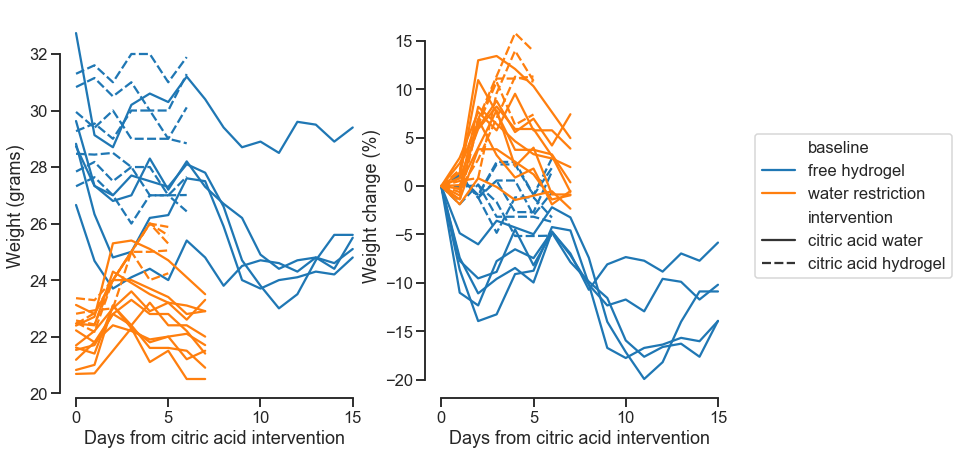

In [92]:
## NOW PLOT WITH SEABORN
f, ax = plt.subplots(1,2, sharex=True, figsize=(12, 7))

sns.lineplot(x="days", y="weight", hue="baseline", style="intervention", 
                  estimator=None, units="mouse", data=data, ax=ax[0])
ax[0].set(ylabel="Weight (grams)", xlabel="Days from citric acid intervention")
ax[0].legend_.remove()

# same, but with weight as % from baseline
sns.lineplot(x="days", y="weight_change", hue="baseline", style="intervention", 
                  estimator=None, units="mouse", data=data, ax=ax[1])
ax[1].set(ylabel="Weight change (%)", xlabel="Days from citric acid intervention")
ax[1].legend(loc='center right', bbox_to_anchor=(1.75, 0.5), ncol=1) # move box outside
sns.despine(offset=2, trim=True)